In [32]:
import numpy as np
from pyquil.quil import Program

def damping_channel(damp_prob=.1):
    """
    Generate the Kraus operators corresponding to an amplitude damping
    noise channel.

    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    damping_op = np.sqrt(damp_prob) * np.array([[0, 1],
                                                [0, 0]])

    residual_kraus = np.diag([1, np.sqrt(1-damp_prob)])
    return [residual_kraus, damping_op]

def append_kraus_to_gate(kraus_ops, g):
    """
    Follow a gate `g` by a Kraus map described by `kraus_ops`.

    :param list kraus_ops: The Kraus operators.
    :param numpy.ndarray g: The unitary gate.
    :return: A list of transformed Kraus operators.
    """
    return [kj.dot(g) for kj in kraus_ops]


def append_damping_to_gate(gate, damp_prob=.1):
    """
    Generate the Kraus operators corresponding to a given unitary
    single qubit gate followed by an amplitude damping noise channel.

    :params np.ndarray|list gate: The 2x2 unitary gate matrix.
    :params float damp_prob: The one-step damping probability.
    :return: A list [k1, k2] of the Kraus operators that parametrize the map.
    :rtype: list
    """
    return append_kraus_to_gate(damping_channel(damp_prob), gate)



In [33]:
from pyquil.api import get_qc
from pyquil.gates import *

# p = Program()
# ro = p.declare('ro', 'BIT', 1)
# p += X(0)
# p += MEASURE(0, ro[0])

# print(p)
# qc = get_qc('1q-qvm')  # You can make any 'nq-qvm' this way for any reasonable 'n'
# # executable = qc.compile(p)
# # result = qc.run(executable)
# p.wrap_in_numshots_loop(1000)
# result = qc.run(p)
# bitstrings = result.readout_data.get('ro')
# print(bitstrings)

# 20% chance of a X gate being applied after gate applications and before measurements.
noisy_qc = get_qc("1q-qvm")
noisy_qc.qam.gate_noise=(0.2, 0.0, 0.0)
noisy_qc.qam.measurement_noise=(0.2, 0.0, 0.0)
p = Program()
ro = p.declare('ro', 'BIT', 1)
p += X(0)
p += MEASURE(0, ro[0])
p.wrap_in_numshots_loop(10)

print("Without Noise:")
print(qc.run(p).readout_data.get("ro"))
print("With Noise:")
print(noisy_qc.run(p).readout_data.get("ro"))



Without Noise:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]]
With Noise:
[[1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]]


In [39]:
qc = get_qc("2q-qvm")
noisy_qc = get_qc("2q-noisy-qvm")
p = Program()
ro = p.declare('ro', 'BIT', 1)
p += X(0)
p += MEASURE(0, ro[0])
p.wrap_in_numshots_loop(10)


print("Without Noise:")
print(qc.run(p).readout_data.get("ro"))
print("With Noise:")
print(noisy_qc.run(p).readout_data.get("ro"))

Without Noise:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]]
With Noise:
[[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]]


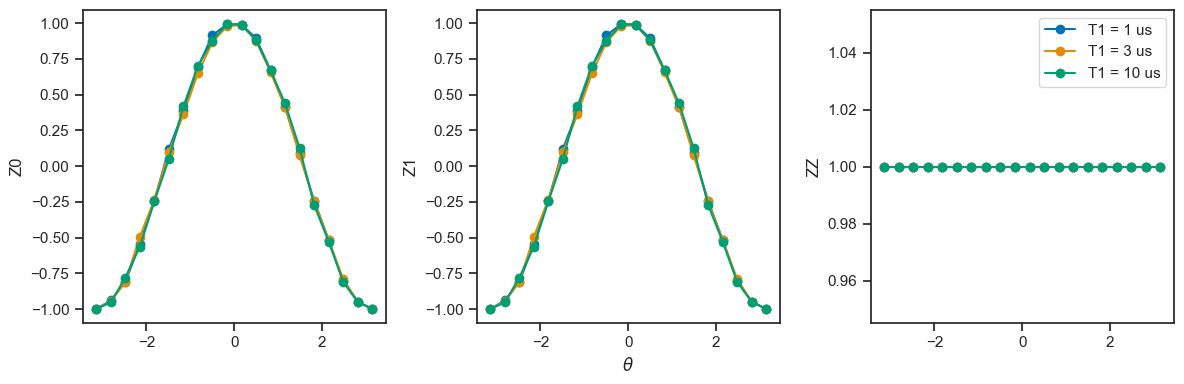

In [41]:
from pyquil.api import get_qc
import numpy as np
from numpy import pi
from pyquil.quil import Program
from pyquil.gates import *
from pyquil.noise import add_decoherence_noise


def get_compiled_prog(theta):
        return Program([
            RZ(-pi/2, 0),
            RX(-pi/2, 0),
            RZ(-pi/2, 1),
            RX( pi/2, 1),
            CZ(1, 0),
            RZ(-pi/2, 1),
            RX(-pi/2, 1),
            RZ(theta, 1),
            RX( pi/2, 1),
            CZ(1, 0),
            RX( pi/2, 0),
            RZ( pi/2, 0),
            RZ(-pi/2, 1),
            RX( pi/2, 1),
            RZ(-pi/2, 1),
        ])


qc = get_qc("Aspen-M-2-qvm")
t1s = np.logspace(-6, -5, num=3)
thetas = np.linspace(-pi, pi, num=20)
t1s * 1e6 # us
records = []
for theta in thetas:
    for t1 in t1s:
        noisy = get_compiled_prog(theta)
        noisy = add_decoherence_noise(noisy, T1=t1, T2=t1/3)
        noisy.declare("ro", "BIT", 2) 
        noisy += MEASURE(0, ("ro", 0))
        noisy += MEASURE(1, ("ro", 1))
        noisy.wrap_in_numshots_loop(1000)
        # noisy = qc.compile(noisy)
        bitstrings = qc.run(noisy).readout_data.get("ro")
        bitstrings = np.array(bitstrings)
        

        # Expectation of Z0 and Z1
        z0, z1 = 1 - 2*np.mean(bitstrings, axis=0)

        # Expectation of ZZ by computing the parity of each pair
        zz = 1 - (np.sum(bitstrings, axis=1) % 2).mean() * 2

        record = {
            'z0': z0,
            'z1': z1,
            'zz': zz,
            'theta': theta,
            't1': t1,
        }
        records += [record]

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='ticks', palette='colorblind')
import pandas as pd
df_all = pd.DataFrame(records)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))

for t1 in t1s:
    df = df_all.query('t1 == @t1')

    ax1.plot(df['theta'], df['z0'], 'o-')
    ax2.plot(df['theta'], df['z1'], 'o-')
    ax3.plot(df['theta'], df['zz'], 'o-', label='T1 = {:.0f} us'.format(t1*1e6))

ax3.legend(loc='best')

ax1.set_ylabel('Z0')
ax2.set_ylabel('Z1')
ax3.set_ylabel('ZZ')
ax2.set_xlabel(r'$\theta$')
fig.tight_layout()